To open it in colab, follow this [link](https://colab.research.google.com/github/eemlcommunity/PracticalSessions2023/blob/main/diffusion/rectified_flow_solutions.ipynb).

# Rectified Flows

In this tutorial, we'll focus on [Rectified Flows (RFs)](https://arxiv.org/abs/2209.03003).

In general, RFs or [Flow Matching models](https://arxiv.org/abs/2210.02747) are closer to [Neural ODEs](https://arxiv.org/abs/1806.07366) and [continuous-time flows](https://arxiv.org/abs/1709.01179).

However, their certain instantiations fit well into the framework of Gaussian diffusion models, and this is how we will view RFs here.

# Installs, imports, and utils

In [1]:
!pip install -q git+https://github.com/deepmind/dm-haiku

  Preparing metadata (setup.py) ... done


In [2]:
from typing import Optional, Callable, Sequence
import functools
import jax
import optax
import dataclasses
import numpy as np
import haiku as hk
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
def bcast_right(x: jax.Array, ndim: int) -> jax.Array:
    """Util function for broadcasting to the right."""
    if x.ndim > ndim:
      raise ValueError(f'Cannot broadcast a value with {x.ndim} dims to {ndim} dims.')
    elif x.ndim < ndim:
      difference = ndim - x.ndim
      return x.reshape(x.shape + difference * (1,))
    else:
      return x

# Toy 2D data

In [4]:
def create_checkerboard_data(num_datapoints: int, rng_seed: int = 42) -> np.ndarray:
  """Checkerboard dataset."""
  rng = np.random.RandomState(rng_seed)
  x1 = rng.rand(num_datapoints) * 4 - 2
  x2 = rng.rand(num_datapoints) - rng.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) # normalize
  return data.astype(np.float32)


def dataset_iterator(data: np.ndarray, batch_size: int, rng_seed: int=42):
  """ TF dataset iterator."""
  train_dataset = tf.data.Dataset.from_tensor_slices(tf.constant(data, tf.float32))
  train_dataset = train_dataset.shuffle(buffer_size=10000)
  train_dataset = train_dataset.repeat()
  train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
  train_dataset = tfds.as_numpy(train_dataset)
  return iter(train_dataset)


train_data = create_checkerboard_data(1000000)
train_data_iter = dataset_iterator(train_data, batch_size=2048)


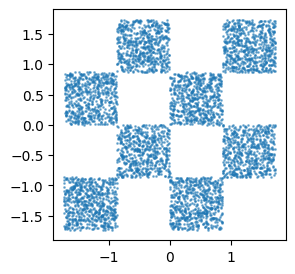

In [5]:
def plot_data(data: np.ndarray):
  plt.figure(figsize=(3, 3))
  plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
  plt.show()

plot_data(train_data[:5000])

# Background

Let's say we have two distributions: $\pi_0$ and $\pi_1$, which in general, can be arbitrary.

Here, we will focus on a particular case where $\pi_0$ is a data distribution and $\pi_1 = N(0,I)$.

In a Rectified Flow, we learn an ODE that would allow us to move data points from $\pi_0$ to data points from $\pi_1$:

$$\frac{dx_t}{dt} = v_{\theta}(x_t, t), \; \text{ with } t \in [0,1], \text{starting from } x_0 \sim \pi_0 $$

At $t=1$, we would like to arrive to $x_1 \sim N(0, 1)$.

What is $x_t$ in this equation?

Rectified Flows construct $x_t$ as a linear interpolation between data $x_0 \sim \pi_0$ and  noise $x_1 = \epsilon \sim N(0,1)$:

\begin{equation}
  x_t = (1-t) x_0 + t \epsilon \tag{1}
\end{equation}

## Rectified Flow "forward process"

Think about similarities between Eq.(1) and the forward process in DDPM defined by the transition distribution $q(x_t|x_0) = N(x_t; \alpha_t x_0, \sigma_t^2 I)$. Afterwards, you should be able to implement methods `alpha(t)` and `sigma(t) `for the class below.

In [6]:
class RectifiedFlowProcess:
  def __init__(self):
    self._tmin = 0.
    self._tmax = 1.

  @property
  def tmin(self):
    return self._tmin

  @property
  def tmax(self):
    return self._tmax


  def alpha(self, t: jax.Array) -> jax.Array:
    return 1.0 - t

  def sigma(self, t: jax.Array) -> jax.Array:
    return t

  def sample(self, x0: jax.Array, t: jax.Array, eps: jax.Array) -> jax.Array:
    """Draws samples from the forward diffusion process."""
    alpha_t = bcast_right(self.alpha(t), x0.ndim)
    sigma_t = bcast_right(self.sigma(t), x0.ndim)
    return alpha_t * x0 + sigma_t * eps

### Visualize RF process properties

Compare the plots below to those of DDPM.

In RFs, we move at a constant speed between a clean image and a Gaussian noise.

This results in more gradual noising compared to the DDPM's noise schedule.

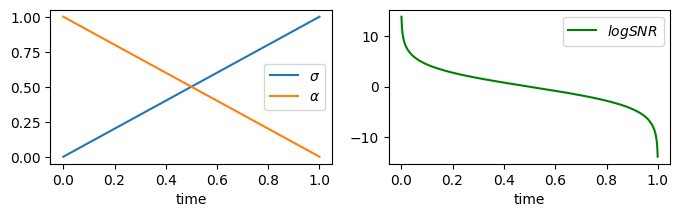

In [7]:
process = RectifiedFlowProcess()
ts = np.linspace(process.tmin, process.tmax, 1000)

fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 2))

# plot how alpha and sigma change over time
ax[0].plot(ts, process.sigma(ts), label=r'$\sigma$')
ax[0].plot(ts, process.alpha(ts), label=r'$\alpha$')
ax[0].set_xlabel('time')
ax[0].legend()

# It is often helpful to reason in terms of signal-to-noise ratio:
# SNR = alpha(t)^2 / sigma(t)^2 or more conveniently, its logarithm.
# High SNR = little noise, low SNR = a lot of noise.
lambda_ = [2. * np.log(process.alpha(t) / process.sigma(t)) for t in ts[1:-1]]
ax[1].plot(ts[1:-1], lambda_, c='g', label=r'$log SNR$')
ax[1].set_xlabel('time')
ax[1].legend()

plt.show()

In [8]:
mnist = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None).to_numpy()
img = mnist[0, 1:].reshape((28, 28))
img = 2 * img / 255. - 1. # rescale from [0,255] to [-1,1]

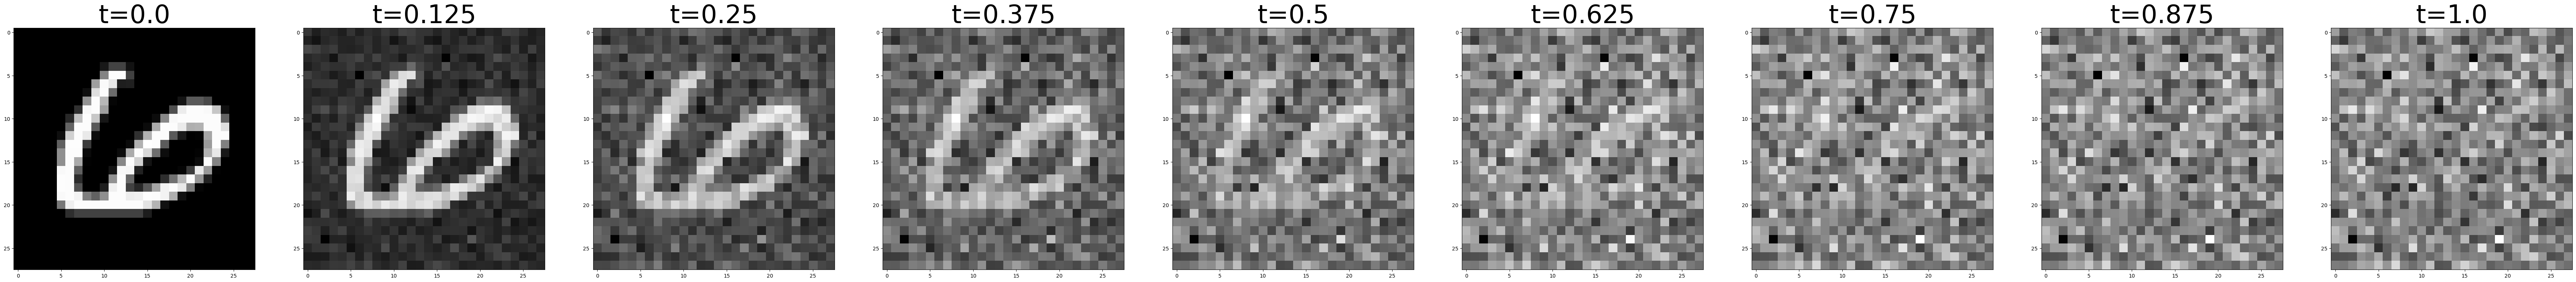

In [9]:
timesteps = np.linspace(process.tmin, process.tmax, 9)
eps = np.random.normal(size=img.shape)

fig, ax = plt.subplots(1, len(timesteps) , figsize=(10 * len(timesteps), 10))

for i, t in enumerate(timesteps):
  img_t = process.sample(img, t, eps)
  ax[i].imshow(img_t, cmap='gray')
  ax[i].set_title(f't={t}', fontsize=50)

## Vector fields


Remember our ODE:

$$\frac{dx_t}{dt} = v_{\theta}(x_t, t).$$

If we follow this ODE from $t=0$ with $x_0 \sim \pi_0$, we want to arrive to $x_1 \sim N(0,I)$ at $t=1$.

If we follow it in reverse, and start from $x_1 \sim N(0,I)$, we can obtain a solution of this ODE at $t=0$.

This solution would be a sample from our Rectified Flow generative model.

<br/>
Obviously, we need to train our model to be able to do it, namely we need to learn the time-dependent vector field part  $v_{\theta}$.

As its inputs, this vector field takes timestep $t \in [0, 1]$ and $x_t \in \mathbb R^d $.

Given these inputs, its output is a vector in $\mathbb R^d$
that describes an infinitesimal change in $x_t$.

<br />
To parameterize this vector field, we can use the same architecture as we used for $\widehat \epsilon(x_t,t; \theta)$ in DDPM.


## Network

In [10]:
class ResidualMLP(hk.Module):
  """MLP with residual connections."""

  def __init__(
      self,
      n_blocks: int,
      n_hidden: int,
      n_out: int,
      activation: str,
      name: str = 'MLP',
  ):
    super().__init__(name=name)
    self._n_blocks = n_blocks
    self._n_hidden = n_hidden
    self._n_out = n_out
    self._activation = getattr(jax.nn, activation)


  def __call__(self, xt: jax.Array, time: jax.Array) -> jax.Array:

    x = hk.Linear(output_size=self._n_hidden)(xt)

    for _ in range(self._n_blocks):
      h = self._activation(x)
      h = hk.Linear(output_size = self._n_hidden)(h)
      h += hk.Linear(output_size = self._n_hidden)(time)
      h = self._activation(h)
      h = hk.Linear(output_size = self._n_hidden)(h)
      x += h

    outputs = hk.Linear(output_size=self._n_out, w_init=hk.initializers.Constant(0.))(x)

    return outputs

In [11]:
class SinusoidalTimeEmbedding(hk.Module):
  """Time (positional) embedding as in Transformers."""

  def __init__(self, num_features: int, name: Optional[str] = None):
    super().__init__(name=name)
    self._num_features = num_features

  def __call__(self, inputs: jax.Array) -> jax.Array:
    assert len(inputs.shape) == 1
    half_dim = self._num_features // 2
    e = np.log(10000) / (half_dim - 1)
    embedding = jnp.exp(-e * jnp.arange(half_dim))
    # time is from 0 to 1, so we recale it to get similar time embeddings as in DDPM
    inputs_rescaled = inputs * 1000
    embedding = inputs_rescaled[:, None] * embedding
    embedding = jnp.concatenate([jnp.cos(embedding), jnp.sin(embedding)], axis=-1)
    if self._num_features % 2 == 1:
      embedding = jnp.pad(embedding, ((0, 0), (0, 1)))
    return embedding

In [12]:
@dataclasses.dataclass
class NetConfig:
  resnet_n_blocks: int = 2
  resnet_n_hidden: int = 256
  resnet_n_out: int = 2
  activation: str = 'elu'
  time_embedding_dim: int = 256


class Net(hk.Module):
  def __init__(self, net_config: NetConfig, name: Optional[str] = None):
    super().__init__(name=name)

    self._time_encoder = SinusoidalTimeEmbedding(net_config.time_embedding_dim)
    self._predictor = ResidualMLP(n_blocks=net_config.resnet_n_blocks,
                                  n_hidden = net_config.resnet_n_hidden,
                                  n_out = net_config.resnet_n_out,
                                  activation = net_config.activation)

  def __call__(self, noisy_data: jax.Array, time: jax.Array) -> jax.Array:
    time_embedding = self._time_encoder(time)
    outputs = self._predictor(noisy_data, time_embedding)
    return outputs

## Objective function

Given a sample $x_0 \sim \pi_0$ and a sample $x_1 \sim N(0,I)$, the simplest ODE that takes us from one to another is straight line:

$$\frac{dx_t}{dt} = x_1-x_0, $$

which corresponds to the time derivative of $x_t$ in the forward process from Eq.(1).

To train our model $v_{\theta}$, we can make it match these straight trajectories that are conditioned on the end points.

We can write the resulting loss as:

$$ \mathbb E_{x_0 \sim \pi_0, \; x_1 \sim N(0, I), \; t\sim U(0, 1)}|| v_{\theta}(x_t, t) - (x_1-x_0) ||^2  $$


## Time sampler
Implement this simple one-line sampler from a standard uniform distribution.

In [13]:
class UniformTimeSampler:
  def __init__(self, tmin: float = 0., tmax: float=1.):
    self._tmin = tmin
    self._tmax = tmax

  def sample(self, key: jax.Array, shape: Sequence[int]) -> jax.Array:
    return jax.random.uniform(key, shape, minval=self._tmin, maxval=self._tmax)

# Full Rectified Flow model

Please fill in the implementation of the loss function in `loss` and `loss_per_timesteps` methods.

</br>

For sampling, we need to get the solution to our ODE at $t=0$.

Please implement one step of the Euler method: `body_fn` inside `sample`.


In [14]:
class DiffusionModel:
  """Rectified Flow model implemented as a DiffusionModel class."""

  def __init__(self, diffusion_process: RectifiedFlowProcess,
               time_sampler: UniformTimeSampler,
               net_config: NetConfig,
               data_shape: tuple[int, ...]):
    super().__init__()

    self._process = diffusion_process
    self._time_sampler = time_sampler
    self._net_config = net_config
    self._data_shape = data_shape

    # don't worry about this haiku stuff.
    # the important bit is to get two pure functions:
    # net_init(rng_key, noisy_data, time) and net_apply(params, noisy_data, time)
    # so that afterwards we can use only jax
    def net_fwd(x, t):
      net = Net(net_config)
      return net(x, t)

    self.net_init, self.net_apply = hk.without_apply_rng(hk.transform(net_fwd))

  def init(self, rng_key: jax.Array, x0: jax.Array) -> hk.Params:
    time = jnp.zeros((x0.shape[0],))
    params = self.net_init(rng_key, x0, time)
    return params


  @functools.partial(jax.jit, static_argnums=(0,))
  def loss(self, params: hk.Params, rng_key: jax.Array, x0: jax.Array) -> jax.Array:
    """Computes MSE between the conditional vector field (x1 - x0) and a vector field given by our neural net."""

    subkey_eps, subkey_t = jax.random.split(rng_key)

    t = self._time_sampler.sample(key=subkey_t, shape=(x0.shape[0],)) # sample time

    eps = jax.random.normal(key=subkey_eps, shape=x0.shape) # sample noise

    xt = self._process.sample(x0, t, eps) # corrupt the data

    net_outputs = self.net_apply(params, xt, t) # get net outputs

    target = eps - x0
    loss = jnp.mean((net_outputs - target) ** 2)

    return loss


  @functools.partial(jax.jit, static_argnums=(0,))
  def loss_per_timesteps(self, params: hk.Params, x0: jax.Array, eps: jax.Array, timesteps: jax.Array) -> jax.Array:
    """ Computes loss values at given timesteps."""
    losses = []
    for t in timesteps:
      t = t * jnp.ones((x0.shape[0],), dtype=jnp.int32)
      xt = self._process.sample(x0, t, eps)
      net_outputs = self.net_apply(params, xt, t)

      # solution
      loss = jnp.mean((net_outputs - (eps - x0)) ** 2)
      losses.append(loss)
    return jnp.asarray(losses)

  @functools.partial(jax.jit, static_argnums=(0,3,4))
  def sample(self, params: hk.Params, rng_key: jax.Array, n_samples: int, n_steps: int = 100) -> jax.Array:
    """Sampling is done by solving the ODE using Euler method.

      dx/dt = v(x(t), t) with x(1) ~ N(0,1),
      and we want to get a solution at t=0.
    """

    v = functools.partial(self.net_apply, params)

    timesteps = jnp.linspace(self._process.tmin, self._process.tmax, n_steps)
    # we solve the ODE from noise at t=1 to data at t=0
    timesteps = timesteps[::-1]

    # x_init is the noise at t=1
    x_init = jax.random.normal(key=rng_key, shape=(n_samples,) + self._data_shape)

    def body_fn(step: int, xt: jax.Array) -> jax.Array:
      t, s = timesteps[step], timesteps[step + 1]
      t, s = t * jnp.ones((xt.shape[0],)), s * jnp.ones((xt.shape[0],))
      h = bcast_right(s - t, xt.ndim)
      return xt + h * v(xt, t)

    return jax.lax.fori_loop(0, n_steps - 1, body_fn, x_init)


# Training

In [15]:
# create the model
diffusion_process = RectifiedFlowProcess()
time_sampler = UniformTimeSampler()
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(2,))

# initialize model parameters
x0_init = next(train_data_iter)
rng_key = jax.random.PRNGKey(42)
params = model.init(rng_key, x0_init)
num_parameters = hk.data_structures.tree_size(params)
print(f'Num. params: {num_parameters:,}')

Num. params: 396,034


In [16]:
#@title Optimizer
training_steps = 50_000 # @param

optimizer = optax.chain(
  optax.clip_by_global_norm(max_norm=1),
  optax.scale_by_adam(),
  optax.scale_by_schedule(
            optax.warmup_cosine_decay_schedule(
                init_value=0.,
                peak_value=3e-4,
                warmup_steps=1000,
                decay_steps=training_steps,
                end_value=1e-5,
            )
        ),
  optax.scale(-1.0))

opt_state = optimizer.init(params)

In [17]:
#@title Update function

@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, rng_key: jax.Array, x0_batch: jax.Array):
  rng_key, next_rng_key = jax.random.split(rng_key)

  # evaluate loss for a given batch and params, and compute the gradients
  loss_value, gradients = jax.value_and_grad(model.loss)(params, rng_key, x0_batch)

  # compute Adam updates and new optimizer state
  updates, new_opt_state = optimizer.update(gradients, opt_state)

  # update params
  new_params = optax.apply_updates(params, updates)

  return loss_value, (new_params, new_opt_state, next_rng_key)

In [18]:
#@title Validation dataset

valid_data = create_checkerboard_data(10000, rng_seed=24) # generate some validation data

# fix the noise so that the validation loss is deterministic
rng_key, subkey = jax.random.split(rng_key)
valid_eps = jax.random.normal(key=subkey, shape=valid_data.shape)

# we will evaluate the loss on a fixed set of timesteps
valid_timesteps = jnp.linspace(diffusion_process.tmin, diffusion_process.tmax, 25)

step: 0, validation loss: 1.97079


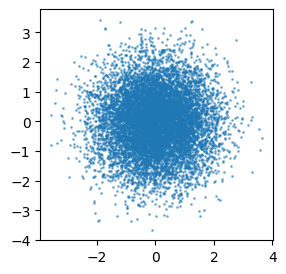

step: 1000, validation loss: 1.47393
step: 2000, validation loss: 1.45797
step: 3000, validation loss: 1.45093
step: 4000, validation loss: 1.44376
step: 5000, validation loss: 1.44117
step: 6000, validation loss: 1.44186
step: 7000, validation loss: 1.43928
step: 8000, validation loss: 1.43969
step: 9000, validation loss: 1.44099
step: 10000, validation loss: 1.43716


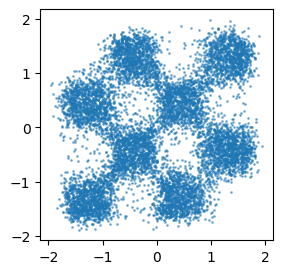

step: 11000, validation loss: 1.43537
step: 12000, validation loss: 1.43536
step: 13000, validation loss: 1.43563
step: 14000, validation loss: 1.43491
step: 15000, validation loss: 1.43426
step: 16000, validation loss: 1.43368
step: 17000, validation loss: 1.43164
step: 18000, validation loss: 1.43297
step: 19000, validation loss: 1.43204
step: 20000, validation loss: 1.43183


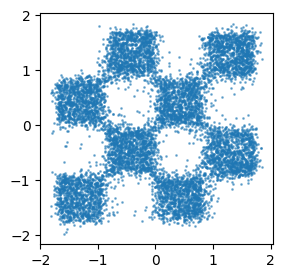

step: 21000, validation loss: 1.43019
step: 22000, validation loss: 1.43036
step: 23000, validation loss: 1.43033
step: 24000, validation loss: 1.43064
step: 25000, validation loss: 1.42985
step: 26000, validation loss: 1.43040
step: 27000, validation loss: 1.42943
step: 28000, validation loss: 1.43053
step: 29000, validation loss: 1.42893
step: 30000, validation loss: 1.42955


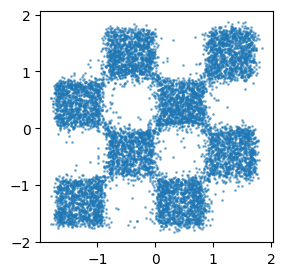

step: 31000, validation loss: 1.42829
step: 32000, validation loss: 1.42963
step: 33000, validation loss: 1.42876
step: 34000, validation loss: 1.42831
step: 35000, validation loss: 1.42749
step: 36000, validation loss: 1.42794
step: 37000, validation loss: 1.42779
step: 38000, validation loss: 1.42770
step: 39000, validation loss: 1.42760
step: 40000, validation loss: 1.42743


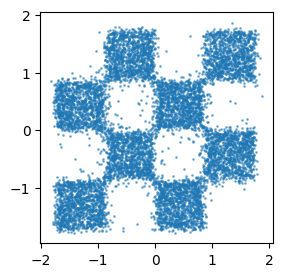

step: 41000, validation loss: 1.42705
step: 42000, validation loss: 1.42739
step: 43000, validation loss: 1.42729
step: 44000, validation loss: 1.42710
step: 45000, validation loss: 1.42682
step: 46000, validation loss: 1.42741
step: 47000, validation loss: 1.42685
step: 48000, validation loss: 1.42674
step: 49000, validation loss: 1.42679


In [19]:
#@title Training loop

for step in range(training_steps):
  x0_batch = next(train_data_iter)
  loss_value, (params, opt_state, rng_key) = update(params, opt_state, rng_key, x0_batch)

  if step % 1000 == 0:
    mean_loss_per_timesteps = np.mean(model.loss_per_timesteps(params, valid_data, valid_eps, valid_timesteps))
    print(f'step: {step}, validation loss: {mean_loss_per_timesteps:.5f}')

  if step % 10000 == 0:
    samples = model.sample(params, rng_key, 10000)
    plot_data(samples)

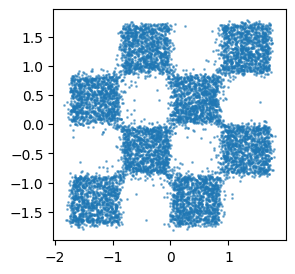

In [20]:
#@title Samples after training
samples = model.sample(params, rng_key, 10000)
plot_data(samples)

## Visualize loss-per-timestep


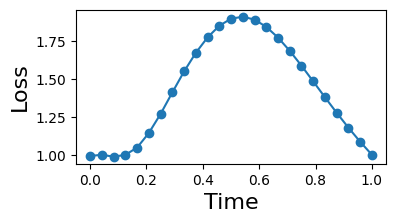

In [21]:
loss_per_timestep = model.loss_per_timesteps(params, valid_data, valid_eps, valid_timesteps)
plt.figure(figsize=(4, 2))
plt.plot(valid_timesteps, loss_per_timestep)
plt.scatter(valid_timesteps, loss_per_timestep)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

## Visualize vector fields



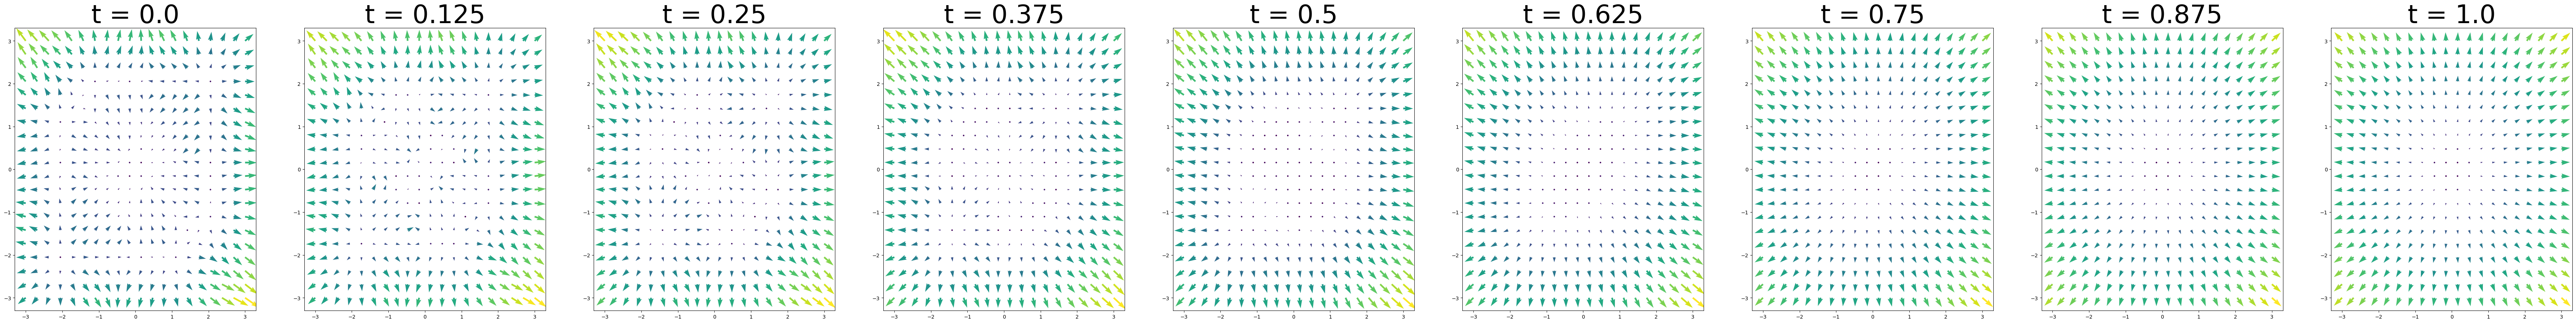

In [22]:
timesteps = np.linspace(process.tmin, process.tmax, 9)
fig, ax = plt.subplots(1, 9 , figsize=(90, 10))
for i, t in enumerate(timesteps):
  x_dim0, x_dim1 = np.meshgrid(np.linspace(-3., 3., 20), np.linspace(-3., 3., 20))
  x = np.stack((x_dim0.flatten(), x_dim1.flatten())).T
  vf = model.net_apply(params, x, t * jnp.ones((x.shape[0],), dtype=jnp.int32))
  color = np.hypot(vf[:, 0], vf[:, 1]) # hypotenuse, longer vectors will be yellower
  ax[i].quiver(x[:, 0], x[:, 1], vf[:, 0], vf[:, 1], color, width=0.007)
  ax[i].set_title(f't = {t}', fontsize=50)
plt.show()

By looking at the loss-per-timestep and these vector fields, what do you think RF learned to predict at t=0 and t=1? Can you compute network predictions and verify your hypothesis (requires some hacking of `DiffusionModel`)?

Note that whatever your conclusion is, it might be valid only for this toy example but not for the general case.